**Audio Classification: Cats vs Dogs vs Birds**
End-to-End MFCC + Deep Learning Pipeline


> This notebook performs audio classification using MFCC features extracted from cat, dog, and bird audio clips.We compare four deep learning models: Dense NN, 1D CNN, LSTM, and a Deep Dense Network.


1. Imports & Setup

In [2]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

2. Dataset Structure Exploration

In [3]:
# ===== EXPLORE DATASET STRUCTURE =====
DATASET_PATH = '/kaggle/input/cats-vs-dogs-vs-birds-audio-classification'

print("Exploring dataset structure...")
print(f"Contents of {DATASET_PATH}:")
for item in os.listdir(DATASET_PATH):
    item_path = os.path.join(DATASET_PATH, item)
    if os.path.isdir(item_path):
        print(f"  [DIR] {item}/")
        # List some files in subdirectories
        files = os.listdir(item_path)[:5]
        for f in files:
            print(f"    - {f}")
        if len(os.listdir(item_path)) > 5:
            print(f"    ... and {len(os.listdir(item_path)) - 5} more files")
    else:
        print(f"  [FILE] {item}")

Exploring dataset structure...
Contents of /kaggle/input/cats-vs-dogs-vs-birds-audio-classification:
  [DIR] Animals/
    - dog
    - bird
    - cat


3. Configurations

In [4]:
# ===== CONFIGURATION =====
SAMPLE_RATE = 22050
DURATION = 3  # seconds
N_MFCC = 40

4. Feature Extraction (MFCC)

In [5]:
# ===== FEATURE EXTRACTION =====
def extract_features(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """Extract MFCC features from audio file"""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        # Pad if shorter than duration
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

5. Load the Dataset

In [6]:
def load_dataset(dataset_path):
    features = []
    labels = []
    
    all_items = os.listdir(dataset_path)
    top_dirs = [item for item in all_items if os.path.isdir(os.path.join(dataset_path, item))]
    
    categories = []
    category_paths = {}
    
    for top_dir in top_dirs:
        top_path = os.path.join(dataset_path, top_dir)
        sub_items = os.listdir(top_path)
        
        audio_files = [f for f in sub_items if f.endswith(('.wav', '.mp3', '.flac'))]
        if audio_files:
            categories.append(top_dir)
            category_paths[top_dir] = top_path
        else:
            sub_dirs = [item for item in sub_items if os.path.isdir(os.path.join(top_path, item))]
            for sub_dir in sub_dirs:
                sub_path = os.path.join(top_path, sub_dir)
                sub_audio = [f for f in os.listdir(sub_path) if f.endswith(('.wav', '.mp3', '.flac'))]
                if sub_audio:
                    categories.append(sub_dir)
                    category_paths[sub_dir] = sub_path
    
    print(f"\nFound categories: {categories}")
    
    if not categories:
        print("ERROR: No audio files found!")
        return np.array([]), np.array([])
    
    for category in categories:
        category_path = category_paths[category]
        all_files = os.listdir(category_path)
        files = [f for f in all_files if f.endswith(('.wav', '.mp3', '.flac'))]
        
        print(f"Processing {len(files)} files from {category}...")
        
        for i, file in enumerate(files):
            file_path = os.path.join(category_path, file)
            feature = extract_features(file_path)
            
            if feature is not None:
                features.append(feature)
                labels.append(category)
            
            if (i + 1) % 50 == 0:
                print(f"  Processed {i + 1}/{len(files)} files")
    
    return np.array(features), np.array(labels)

6. Load X & y

In [7]:
print("\n" + "="*60)
print("Loading dataset...")
print("="*60)
X, y = load_dataset(DATASET_PATH)

if len(X) == 0:
    print("\nERROR: No data loaded! Please check the dataset structure.")
    raise SystemExit("No audio data found in the dataset!")

print(f"\nDataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Unique labels: {np.unique(y)}")
print(f"Label distribution:")
for label in np.unique(y):
    count = np.sum(y == label)
    print(f"  {label}: {count} samples ({count/len(y)*100:.1f}%)")


Loading dataset...

Found categories: ['dog', 'bird', 'cat']
Processing 210 files from dog...
  Processed 50/210 files
  Processed 100/210 files
  Processed 150/210 files
  Processed 200/210 files
Processing 193 files from bird...
  Processed 50/193 files
  Processed 100/193 files
  Processed 150/193 files
Processing 207 files from cat...
  Processed 50/207 files
  Processed 100/207 files
  Processed 150/207 files
  Processed 200/207 files

Dataset loaded: 610 samples, 40 features
Unique labels: ['bird' 'cat' 'dog']
Label distribution:
  bird: 193 samples (31.6%)
  cat: 207 samples (33.9%)
  dog: 210 samples (34.4%)


7. Label Encoding + Train/Test Split

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Classes: {le.classes_}")


Train set: 488 samples
Test set: 122 samples
Classes: ['bird' 'cat' 'dog']


8. Model Definitions

In [9]:
def build_dense_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

1D CNN

In [10]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(input_shape, 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


LSTM

In [11]:
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(input_shape, 1)),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


Deep Dense

In [12]:
def build_deep_dense_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


9. Training Function

In [13]:
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test, epochs=50):
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"\n{model_name} Test Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))
    
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return accuracy, history


10. Train All Models


STARTING MODEL TRAINING

Training Dense NN
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-05 20:17:57.683129: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3279 - loss: 37.6802 - val_accuracy: 0.2959 - val_loss: 4.9342 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3456 - loss: 15.6051 - val_accuracy: 0.3367 - val_loss: 2.3896 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3500 - loss: 10.1220 - val_accuracy: 0.3367 - val_loss: 3.0717 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3583 - loss: 7.7734 - val_accuracy: 0.3367 - val_loss: 1.9729 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3131 - loss: 6.0669 - val_accuracy: 0.3980 - val_loss: 1.5840 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3348 - loss: 5.4589 - val_accuracy: 0.3367 - val_loss: 1.5849 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3350 - loss: 3.9545 - val_accuracy: 0.5000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


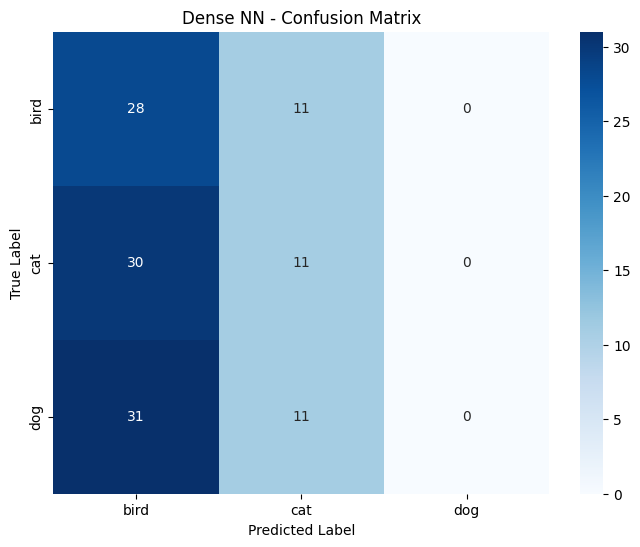

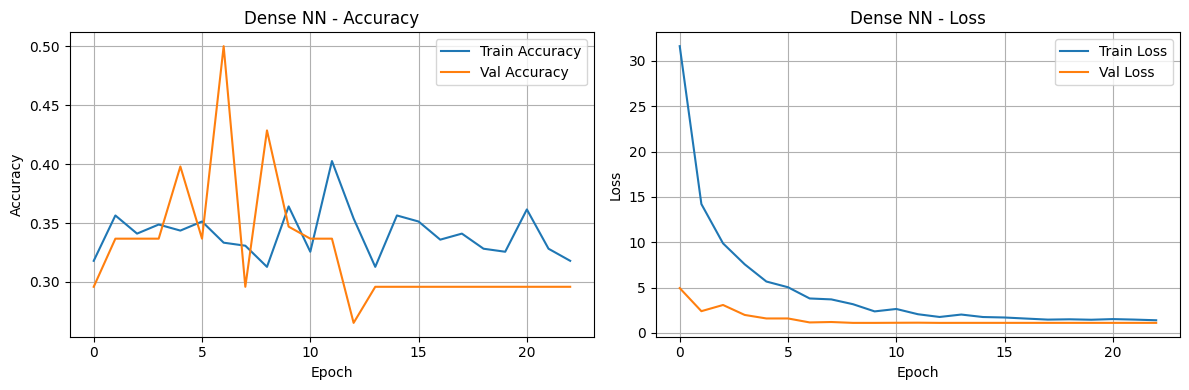


Training 1D CNN
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3753 - loss: 2.5404 - val_accuracy: 0.4490 - val_loss: 1.0357 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3748 - loss: 1.2044 - val_accuracy: 0.5918 - val_loss: 1.0014 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4479 - loss: 1.0403 - val_accuracy: 0.4490 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5553 - loss: 0.9361 - val_accuracy: 0.5510 - val_loss: 0.8660 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6128 - loss: 0.8254 - val_accuracy: 0.6531 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6851 - loss: 0.7630 - val_accuracy: 0.6837 - val_loss: 0.7019 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7089 - loss: 0.6705 - val_accuracy: 0.72

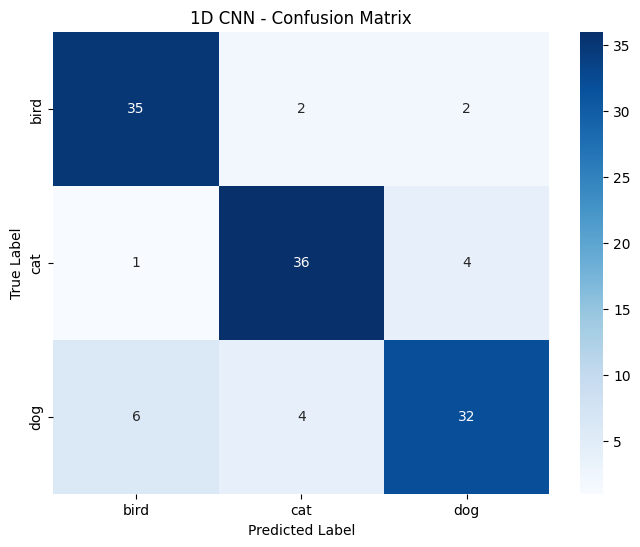

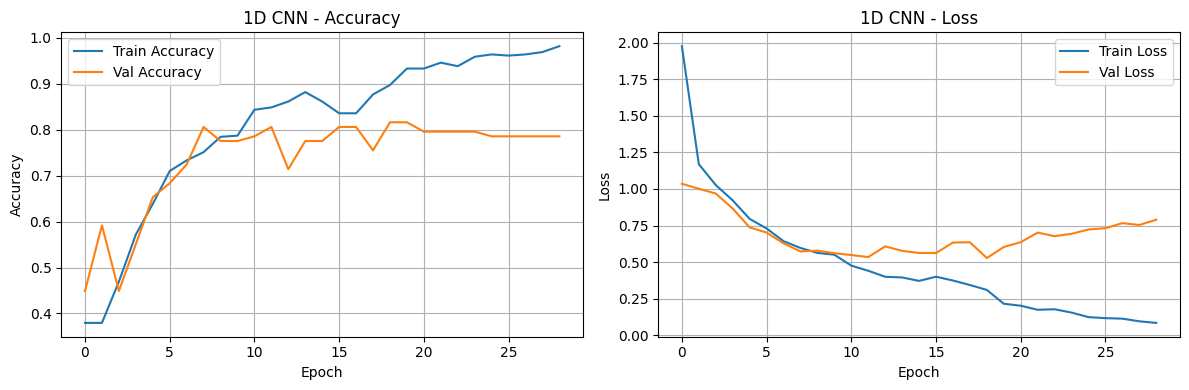


Training LSTM
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.3138 - loss: 1.1023 - val_accuracy: 0.3673 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4056 - loss: 1.0870 - val_accuracy: 0.3469 - val_loss: 1.0911 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3853 - loss: 1.0769 - val_accuracy: 0.3776 - val_loss: 1.0826 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3825 - loss: 1.0622 - val_accuracy: 0.3878 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3955 - loss: 1.0560 - val_accuracy: 0.4082 - val_loss: 1.0662 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4355 - loss: 1.0442 - val_accuracy: 0.4796 - val_loss: 1.0784 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3933 - loss: 1.0632 - val_accuracy: 0.3

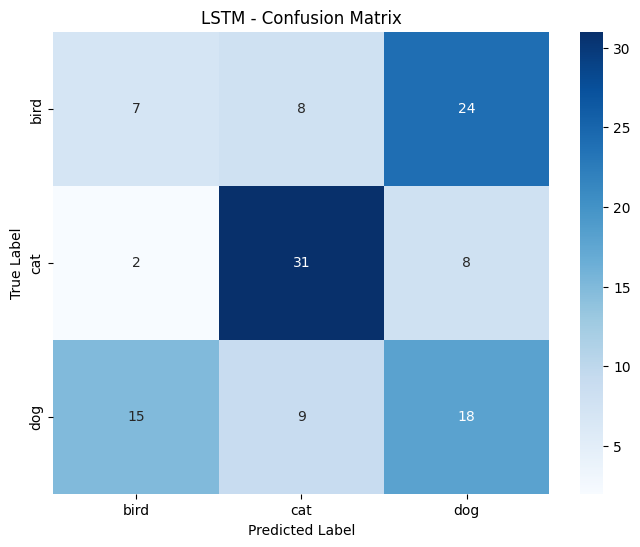

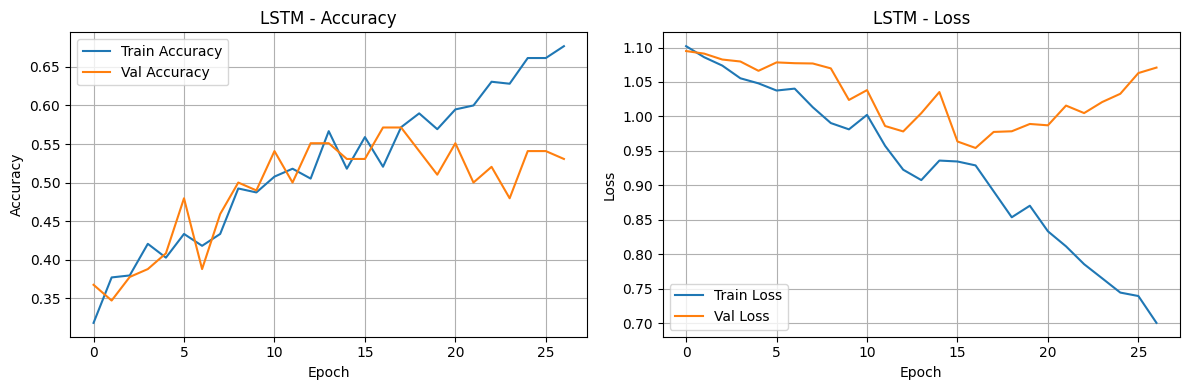


Training Deep Dense NN
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3280 - loss: 1.6232 - val_accuracy: 0.3673 - val_loss: 8.4308 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4406 - loss: 1.3752 - val_accuracy: 0.3673 - val_loss: 5.4268 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4134 - loss: 1.2903 - val_accuracy: 0.3980 - val_loss: 2.7429 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4754 - loss: 1.1889 - val_accuracy: 0.3673 - val_loss: 2.7215 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5418 - loss: 1.0523 - val_accuracy: 0.3673 - val_loss: 2.0399 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5953 - loss: 0.9666 - val_accuracy: 0.3673 - val_loss: 1.9361 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5681 - loss: 1.0085 - val_accuracy: 0.40

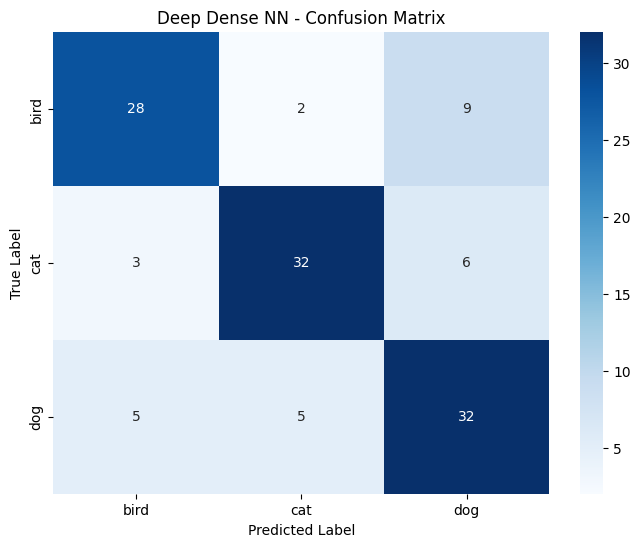

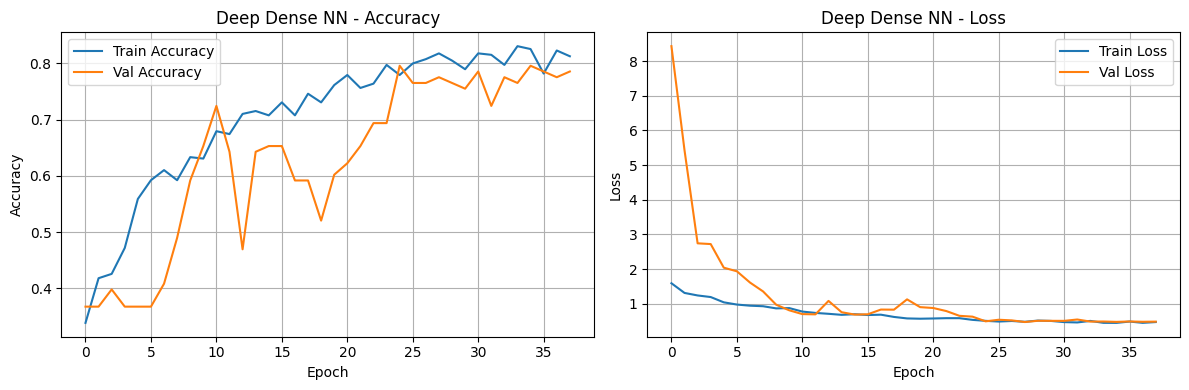

In [14]:
results = {}

print("\n" + "="*60)
print("STARTING MODEL TRAINING")
print("="*60)

# Dense NN
model1 = build_dense_model(X_train.shape[1], y_categorical.shape[1])
acc1, hist1 = train_and_evaluate(model1, "Dense NN", X_train, y_train, X_test, y_test)
results["Dense NN"] = acc1

# 1D CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model2 = build_cnn_model(X_train.shape[1], y_categorical.shape[1])
acc2, hist2 = train_and_evaluate(model2, "1D CNN", X_train_cnn, y_train, X_test_cnn, y_test)
results["1D CNN"] = acc2

# LSTM
model3 = build_lstm_model(X_train.shape[1], y_categorical.shape[1])
acc3, hist3 = train_and_evaluate(model3, "LSTM", X_train_cnn, y_train, X_test_cnn, y_test)
results["LSTM"] = acc3

# Deep Dense NN
model4 = build_deep_dense_model(X_train.shape[1], y_categorical.shape[1])
acc4, hist4 = train_and_evaluate(model4, "Deep Dense NN", X_train, y_train, X_test, y_test)
results["Deep Dense NN"] = acc4


11. Final Comparison


FINAL RESULTS COMPARISON
        Model  Test Accuracy
       1D CNN       0.844262
Deep Dense NN       0.754098
         LSTM       0.459016
     Dense NN       0.319672


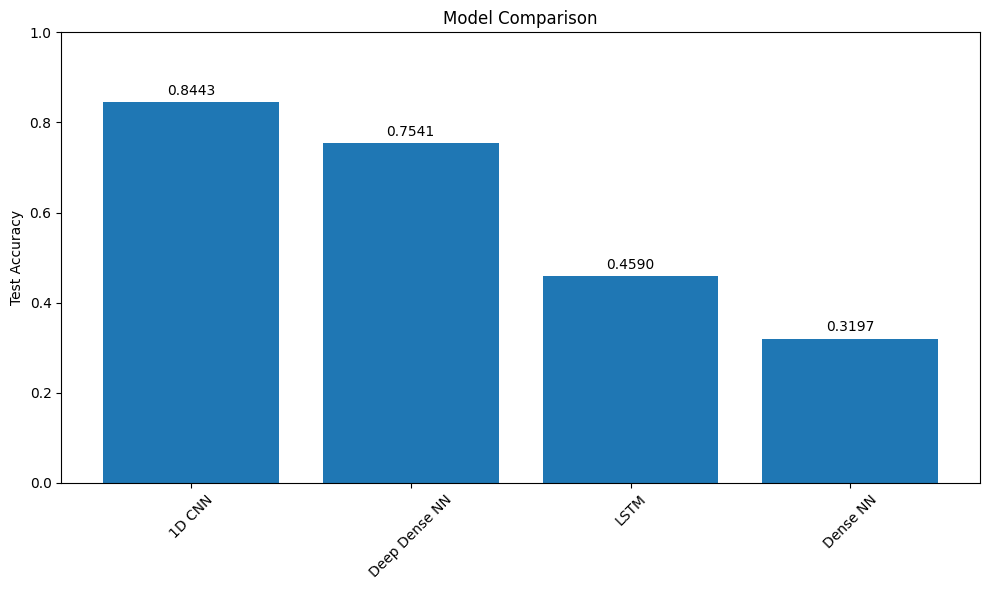


Best Model: 1D CNN with accuracy: 0.8443


In [15]:
print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Test Accuracy'])
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Test Accuracy'])
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.ylim([0, 1])
for i, v in enumerate(results_df['Test Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nBest Model: {results_df.iloc[0]['Model']} with accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")


Combined history plots (accuracy + loss for all models)

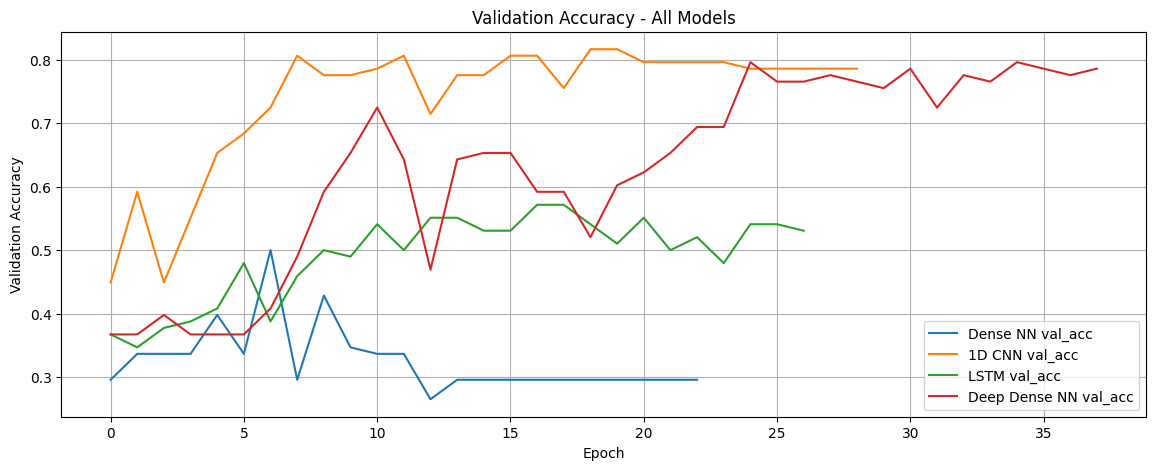

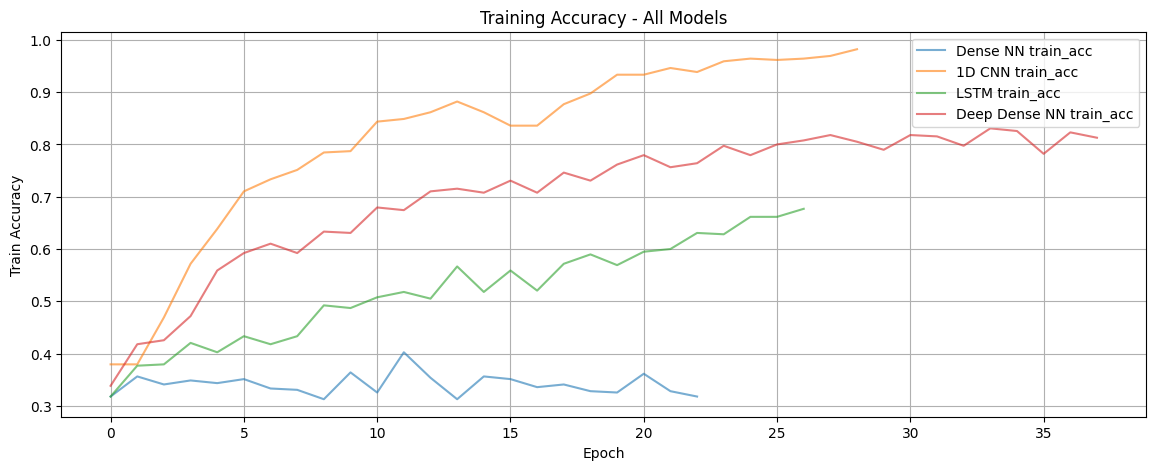

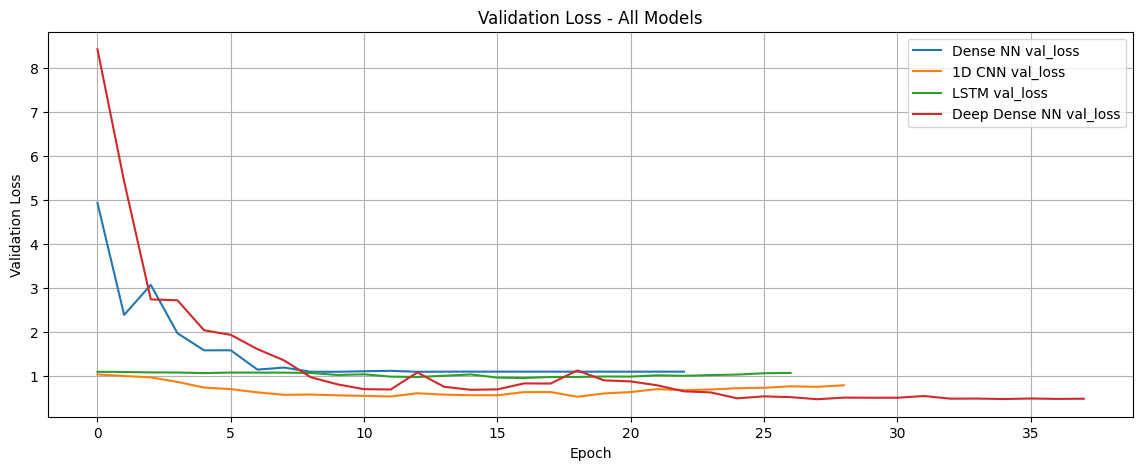

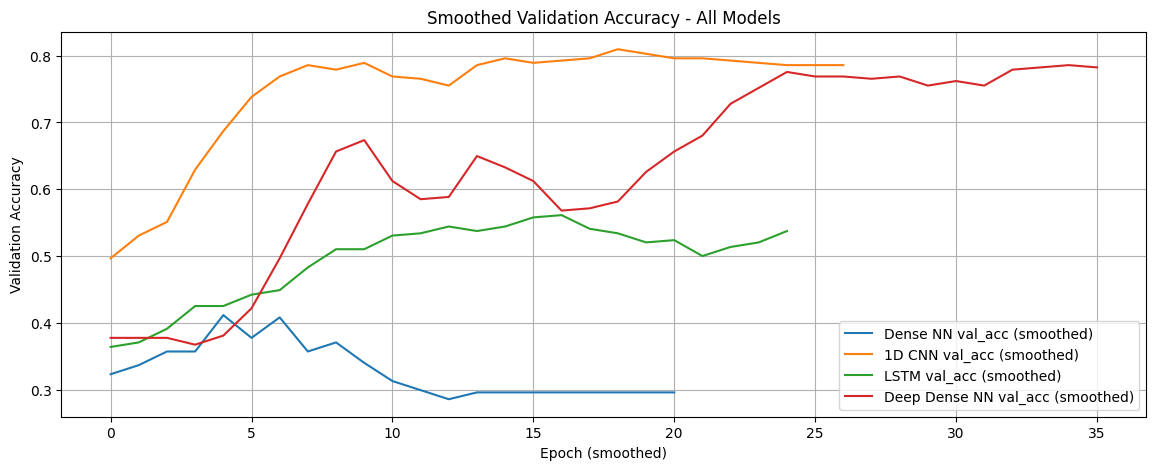

In [16]:
# Combined training histories for all models
import matplotlib.pyplot as plt
import numpy as np

# histories: hist1, hist2, hist3, hist4
histories = {
    "Dense NN": hist1,
    "1D CNN"  : hist2,
    "LSTM"    : hist3,
    "Deep Dense NN": hist4
}

# Plot accuracy for all
plt.figure(figsize=(14,5))
for name, h in histories.items():
    if 'accuracy' in h.history:
        plt.plot(h.history['val_accuracy'], label=f'{name} val_acc')
plt.title('Validation Accuracy - All Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training accuracy for comparison (optional)
plt.figure(figsize=(14,5))
for name, h in histories.items():
    if 'accuracy' in h.history:
        plt.plot(h.history['accuracy'], label=f'{name} train_acc', alpha=0.6)
plt.title('Training Accuracy - All Models')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss for all
plt.figure(figsize=(14,5))
for name, h in histories.items():
    if 'loss' in h.history:
        plt.plot(h.history['val_loss'], label=f'{name} val_loss')
plt.title('Validation Loss - All Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Optional: smooth curves with rolling mean for better visibility
def smooth(x, ws=3):
    return np.convolve(x, np.ones(ws)/ws, mode='valid')

plt.figure(figsize=(14,5))
for name, h in histories.items():
    if 'val_accuracy' in h.history and len(h.history['val_accuracy']) >= 3:
        plt.plot(smooth(h.history['val_accuracy']), label=f'{name} val_acc (smoothed)')
plt.title('Smoothed Validation Accuracy - All Models')
plt.xlabel('Epoch (smoothed)')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



----------------------------------------------------------------------
Sample 1: /kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/bird/c103a2d5_nohash_1.wav
True label (inferred from folder): bird


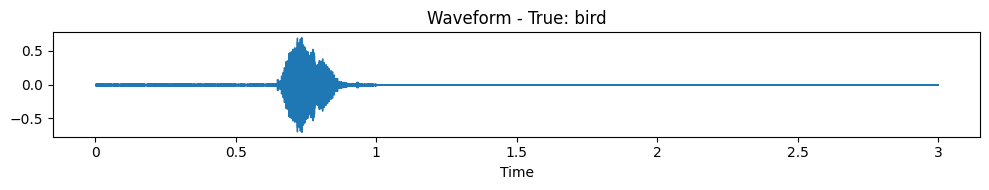

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Model predictions:
  Dense NN: Predicted = cat (0.345), probs = [0.335 0.345 0.32 ]
  Deep Dense NN: Predicted = bird (0.812), probs = [0.812 0.058 0.13 ]
  1D CNN: Predicted = bird (0.933), probs = [0.933 0.015 0.052]
  LSTM: Predicted = cat (0.403), probs = [0.295 0.403 0.302]

----------------------------------------------------------------------
Sample 2: /kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/cat/8335f893_nohash_0.wav
True label (inferred from folder): cat


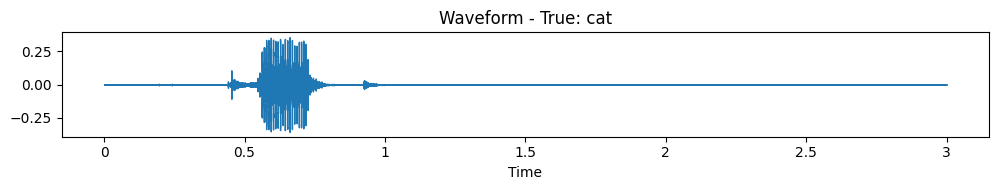

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Model predictions:
  Dense NN: Predicted = bird (0.337), probs = [0.337 0.331 0.332]
  Deep Dense NN: Predicted = cat (0.985), probs = [0.01  0.985 0.005]
  1D CNN: Predicted = cat (0.964), probs = [0.004 0.964 0.032]
  LSTM: Predicted = cat (0.540), probs = [0.253 0.54  0.207]

----------------------------------------------------------------------
Sample 3: /kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/bird/3e31dffe_nohash_0.wav
True label (inferred from folder): bird


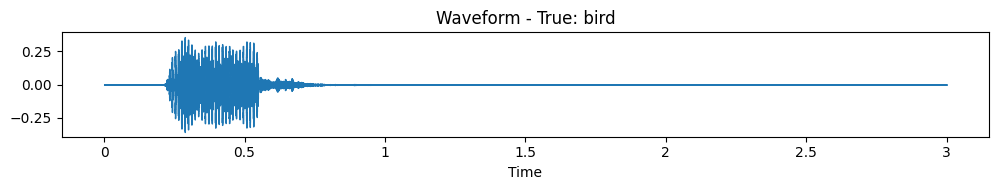

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Model predictions:
  Dense NN: Predicted = bird (0.340), probs = [0.34  0.331 0.329]
  Deep Dense NN: Predicted = bird (0.931), probs = [0.931 0.025 0.045]
  1D CNN: Predicted = bird (0.996), probs = [0.996 0.001 0.003]
  LSTM: Predicted = dog (0.420), probs = [0.372 0.208 0.42 ]

----------------------------------------------------------------------
Sample 4: /kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/dog/9799379a_nohash_0.wav
True label (inferred from folder): dog


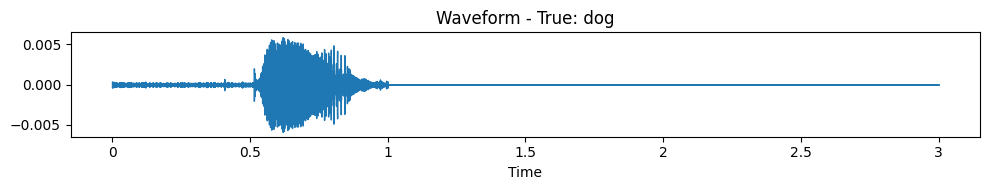

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Model predictions:
  Dense NN: Predicted = bird (0.338), probs = [0.338 0.328 0.334]
  Deep Dense NN: Predicted = dog (0.813), probs = [0.016 0.17  0.813]
  1D CNN: Predicted = dog (0.989), probs = [0.004 0.007 0.989]
  LSTM: Predicted = bird (0.775), probs = [0.775 0.01  0.214]

----------------------------------------------------------------------
Sample 5: /kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals/bird/e55a2b20_nohash_0.wav
True label (inferred from folder): bird


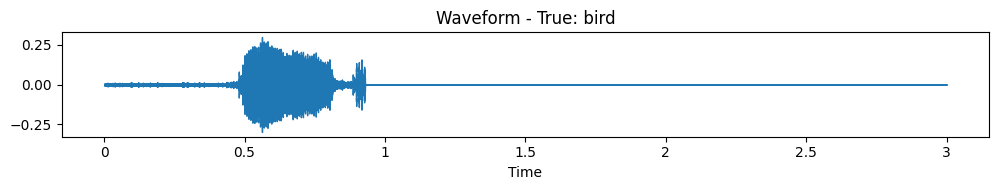

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Model predictions:
  Dense NN: Predicted = bird (0.336), probs = [0.336 0.332 0.332]
  Deep Dense NN: Predicted = bird (0.887), probs = [0.887 0.058 0.056]
  1D CNN: Predicted = bird (0.997), probs = [0.997 0.002 0.002]
  LSTM: Predicted = cat (0.389), probs = [0.264 0.389 0.347]


In [17]:
# Random testing of samples from the dataset directories
import random
import librosa.display
from IPython.display import Audio, display
import os
import numpy as np

def find_audio_files(root_path, exts=('.wav', '.mp3', '.flac')):
    files = []
    for root, dirs, filenames in os.walk(root_path):
        for fn in filenames:
            if fn.lower().endswith(exts):
                files.append(os.path.join(root, fn))
    return files

def infer_label_from_path(path):
    # assume label is the parent directory name (last folder before filename)
    return os.path.basename(os.path.dirname(path))

def predict_with_all_models(feature_vector):
    # feature_vector is 1D MFCC mean vector (shape (N_MFCC,))
    x = feature_vector.reshape(1, -1)           # for dense models
    x_cnn = x.reshape(1, x.shape[1], 1)         # for CNN / LSTM shapes
    preds = {}
    # Dense models expect shape (1, features)
    try:
        preds['Dense NN'] = model1.predict(x)[0]
    except Exception as e:
        preds['Dense NN'] = None
    try:
        preds['Deep Dense NN'] = model4.predict(x)[0]
    except Exception as e:
        preds['Deep Dense NN'] = None
    # CNN / LSTM use (1, features, 1)
    try:
        preds['1D CNN'] = model2.predict(x_cnn)[0]
    except Exception as e:
        preds['1D CNN'] = None
    try:
        preds['LSTM'] = model3.predict(x_cnn)[0]
    except Exception as e:
        preds['LSTM'] = None
    return preds

def pretty_print_preds(preds, classes):
    for m, p in preds.items():
        if p is None:
            print(f"  {m}: (model not available / error)")
            continue
        top_idx = np.argmax(p)
        top_prob = p[top_idx]
        print(f"  {m}: Predicted = {classes[top_idx]} ({top_prob:.3f}), probs = {np.round(p,3)}")

# pick n random samples
n = 5  # change to any number you want
all_audio_files = find_audio_files(DATASET_PATH)
if len(all_audio_files) == 0:
    print("No audio files found under DATASET_PATH. Please ensure DATASET_PATH is correct.")
else:
    samples = random.sample(all_audio_files, min(n, len(all_audio_files)))
    for i, fpath in enumerate(samples, 1):
        print("\n" + "-"*70)
        print(f"Sample {i}: {fpath}")
        true_label = infer_label_from_path(fpath)
        print(f"True label (inferred from folder): {true_label}")
        
        # load audio for display and playback (librosa loads as mono)
        audio, sr = librosa.load(fpath, sr=SAMPLE_RATE, duration=DURATION)
        # Pad to DURATION if needed to keep consistent length for visualization
        if len(audio) < SAMPLE_RATE * DURATION:
            audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)))
        
        # Show waveform
        plt.figure(figsize=(10, 2))
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform - True: {true_label}")
        plt.tight_layout()
        plt.show()
        
        # Play audio
        display(Audio(audio, rate=sr))
        
        # Extract features the same way your pipeline did
        feat = extract_features(fpath)  # returns 1D vector or None
        if feat is None:
            print("Feature extraction failed for this file.")
            continue
        
        preds = predict_with_all_models(feat)
        print("Model predictions:")
        pretty_print_preds(preds, le.classes_)
